In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '..')
from utils import *
from collections import Counter
import geopandas as gpd
import matplotlib.ticker as ticker
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

In [3]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'
NETWORK_DIR = join(pwd, dpath, 'Nets', f'{AREA_NAME}-CBG-CBG-Nets')
nets = [(datetime.strptime(f, '%Y-%m-%d'), ig.Graph.Read_Pickle(join(NETWORK_DIR, f))) 
            for f in tqdm(os.listdir(NETWORK_DIR))]
nets = np.array(sorted(nets, key=lambda x: x[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:30<00:00,  3.47it/s]


In [4]:
area_cbgs = get_CBGS(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json'), dtype=np.int64)

In [5]:
def mean_time_to_work(row, cols):
    '''
    calculates the mean travel to work time with the help of time categories
    '''
    duration = 0
    w = 0
    for col in cols:
        seg = col.split('-')
        minutes = (int(seg[1]) + int(seg[-1])) / 2
        duration += row[col]*minutes
        w += row[col]
    return duration/w

In [6]:
def get_census_attrs(rank_list=[]):
    '''
    reads and prepares the census attributes
    `rank_list` stores the attributes to be worked as ranked values
    '''
    census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'census_attributes.csv'))
    census_attrs = census_attrs[census_attrs['census_block_group'].isin(area_cbgs)]

    commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
    census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

    edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
    census_attrs['education'] = sum([census_attrs[i] for i in edu_cols])

    census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
    census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})

    col_names = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
    quart = ['Bottom', 'Third', 'Second', 'Top']
    for col in col_names:
        census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

    census_quartiles = census_attrs[['census_block_group', *[f'{cn}-quartile' for cn in col_names]]]
    census_raw_values = census_attrs[['census_block_group', *col_names]]
    
    for attr in rank_list:
        census_raw_values[attr] = census_raw_values[attr].rank(pct=True)
    
    return census_quartiles, census_raw_values

In [7]:
def get_quart_cbgs(col, quart, cdf):
    return set(cdf[cdf[f'{col}-quartile'] == quart]['census_block_group'].values.astype(str))

In [8]:
census_quartiles, census_raw_values = get_census_attrs()

In [14]:
tdate = datetime(2019, 12, 24)
tnets = nets[nets[:, 0] >= tdate]
dx = [i[0] for i in tnets]

quarts = ['Bottom', 'Third', 'Second', 'Top']
sel_cols = ['income', 'white_population', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

cent_metrics = [
        ('Closeness', ig.Graph.closeness, {'cutoff': 3, 'normalized': True, 'weights': None}), 
        ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True, 'weights': None}), 
        ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
        ('In-Degree', 'in', None),
        ('Out-Degree', 'out', None),
        ('Total-Degree', 'all', None),
        ('Self-Visit-Ratio', 'self', None)
    ]

results = []
for tp in tqdm(tnets):
    date = tp[0]
    tnet = tp[1]
    nnodes = len(tnet.vs)
    norm = (nnodes-1)*(nnodes-2)
    for cent_metric_name, metric, params in cent_metrics:
        if not isinstance(metric, str) and params:
            values = np.array(metric(tnet, **params))
            if cent_metric_name == 'Betweenness':
                values /= norm
        elif isinstance(metric, str) and not params:
            if metric != 'self':
                values = np.array(tnet.strength(loops=False, mode=metric, weights='visits'))
            else:
                self_visits = np.subtract(tnet.strength(loops=True, mode='in', weights='visits'), tnet.strength(mode='in', loops=False, weights='visits'))
                out_visits = np.array(tnet.strength(loops=False, mode='out', weights='visits'))
                total_visits = self_visits + out_visits + 0.001

                values = self_visits/total_visits
        data = {
            'date': date,
            'cent_name': cent_metric_name,
            'value': np.mean(values)
        }
        
        for col in sel_cols:
            for quart in quarts:
                cbgs = get_quart_cbgs(col, quart, census_quartiles)
                ind = [i for i, v in enumerate(tnet.vs['name']) if v in cbgs]
                data[f'{col}-{quart}'] = np.mean(values[ind])
                
        results.append(data)
        
res = pd.DataFrame(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [11:57<00:00, 13.05s/it]


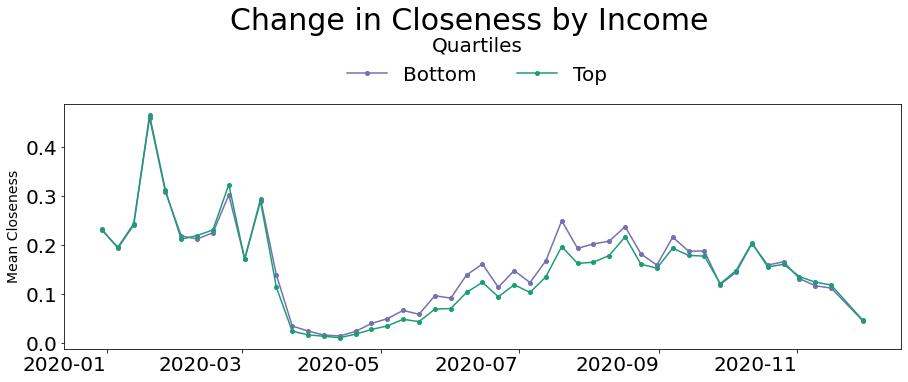

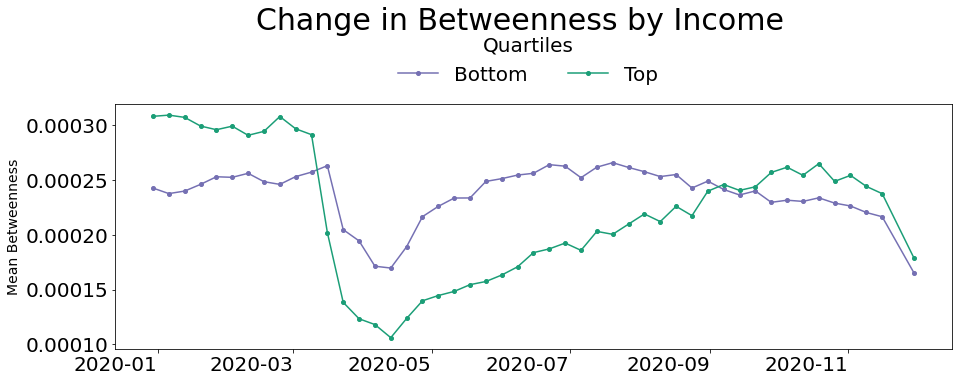

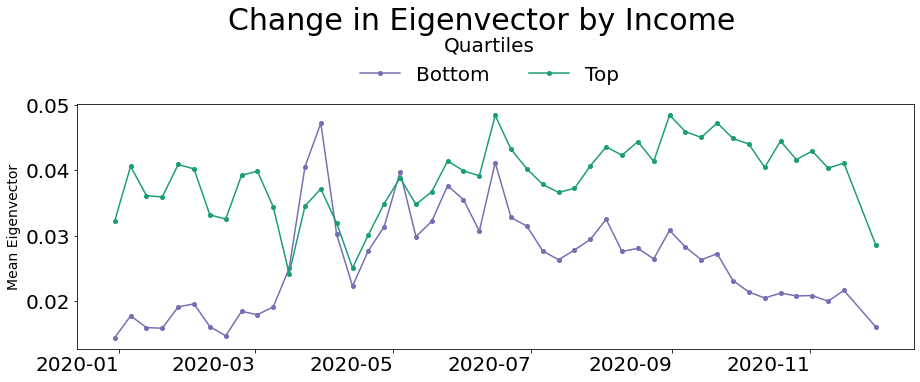

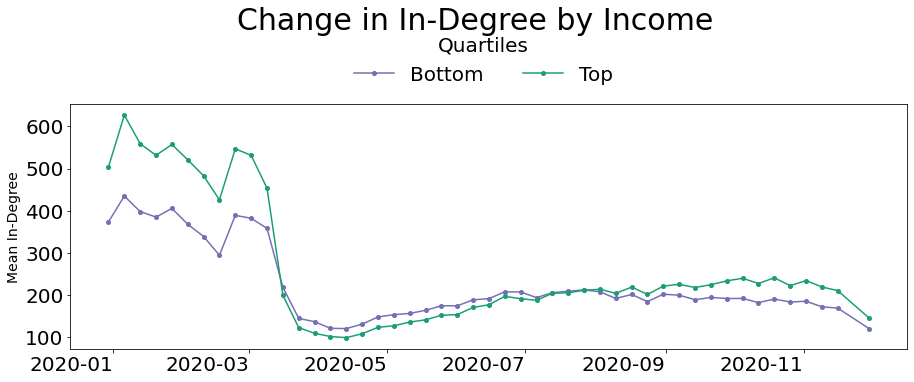

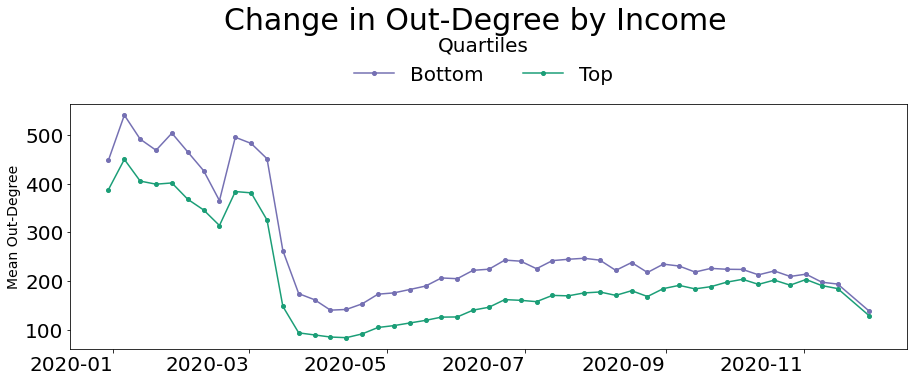

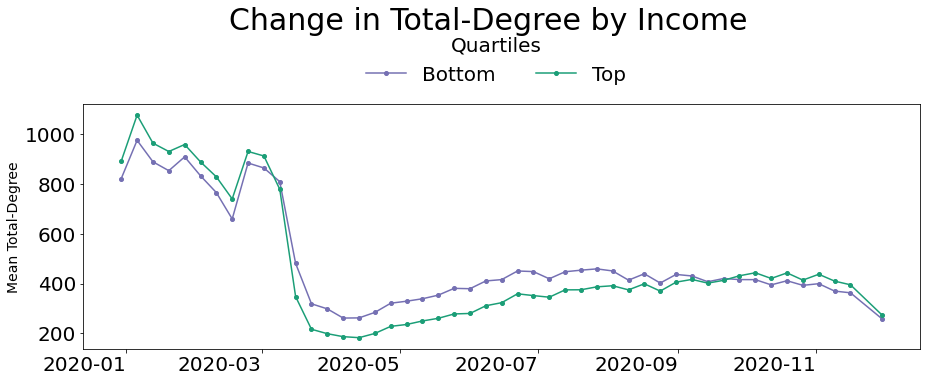

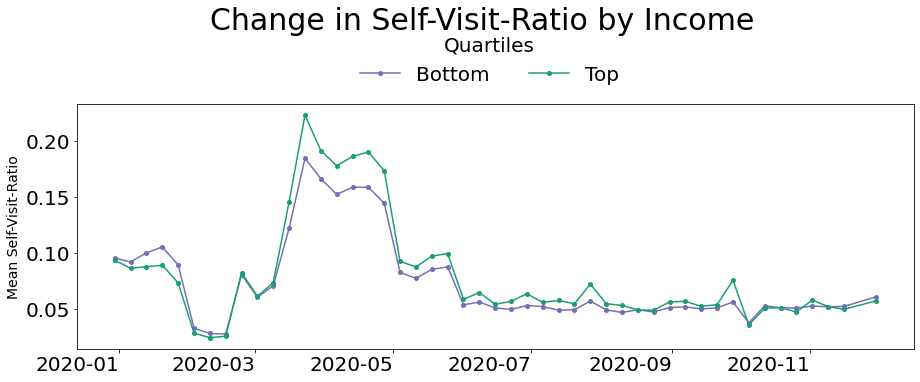

In [53]:
top_color = '#1b9e77'
second_color = '#d95f02'
third_color = '#e7298a'
bottom_color = '#7570b3'

attrs = ['income', 'white_population', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']
attr_name = ['Income', 'White Percentage', 'Black Percentage', 'Asian Percentage', 'Hispanic Percentage', 'Education', 'Mean Time to Work']
quarts = ['Bottom', 'Top']
fdate = datetime(2020, 12, 1)

for ind, attr in enumerate(attrs):
    for cent_metric_name, metric, params in cent_metrics:
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))

        selr = res[res['cent_name'] == cent_metric_name].set_index('date')
        selr = selr.loc[selr.index < fdate]
        selr = selr[[f'{attr}-{q}' for q in quarts]]
        selr.columns = [i.split('-')[1] for i in selr.columns]
        #selr = selr.div(selr.iloc[0], axis=0)
        selr.plot(ax=ax, color=[bottom_color, top_color], rot=0, marker='o', markersize=4)
        ax.set_ylabel(f'Mean {cent_metric_name}', fontsize=14)
        ax.set_xlabel(None)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        ax.legend(bbox_to_anchor=(0.67, 1.35), ncol=4, title='Quartiles', edgecolor='white', fontsize=20, title_fontsize=20)
        fig.suptitle(f'Change in {cent_metric_name} by {attr_name[ind]}', fontsize=30, x=0.5, y=1.15)

        #fig.savefig(f'{attr}-{cent_metric_name}.pdf', dpi=900, bbox_inches='tight')
    break